# Übung 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal

In [3]:
image = plt.imread('../images/lena.tiff')
weights = [0.2989, 0.5870, 0.1140]
gray = np.dot(image[..., :3], weights)

## 1. Kantendetektion

In [4]:
scaling = 0.5
gray_scaled = cv2.resize(gray, dsize=tuple([int(x * scaling) for x in gray.shape]))

In [5]:
def showcase_filter(filter):
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(gray, cmap=plt.get_cmap('gray'))
    ax[1].imshow(filter(gray), cmap=plt.get_cmap('gray'))
    ax[2].imshow(filter(gray_scaled), cmap=plt.get_cmap('gray'))
    plt.show()

a) Laplace Kantendetektor

In [6]:
laplace_kernel = np.array([[0, 1, 0],
                           [1, -4, 1],
                           [0, 1, 0]])
laplace_kernel

array([[ 0,  1,  0],
       [ 1, -4,  1],
       [ 0,  1,  0]])

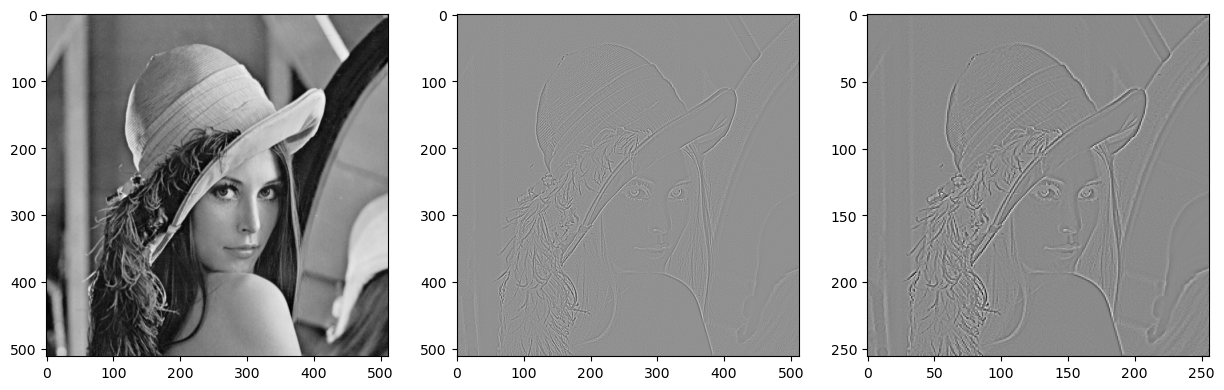

In [7]:
def laplace_filter(img):
    return cv2.filter2D(img, -1, laplace_kernel)


showcase_filter(laplace_filter)
# e) berücksichtigt in Grundform keine Diagonalen, feste Filtergröße, einfach

b) Sobel Kantendetektor

In [8]:
sobel_kernel_v = 1 / 8 * np.array([[1, 0, -1],
                                   [2, 0, -2],
                                   [1, 0, -1]])
sobel_kernel_v

array([[ 0.125,  0.   , -0.125],
       [ 0.25 ,  0.   , -0.25 ],
       [ 0.125,  0.   , -0.125]])

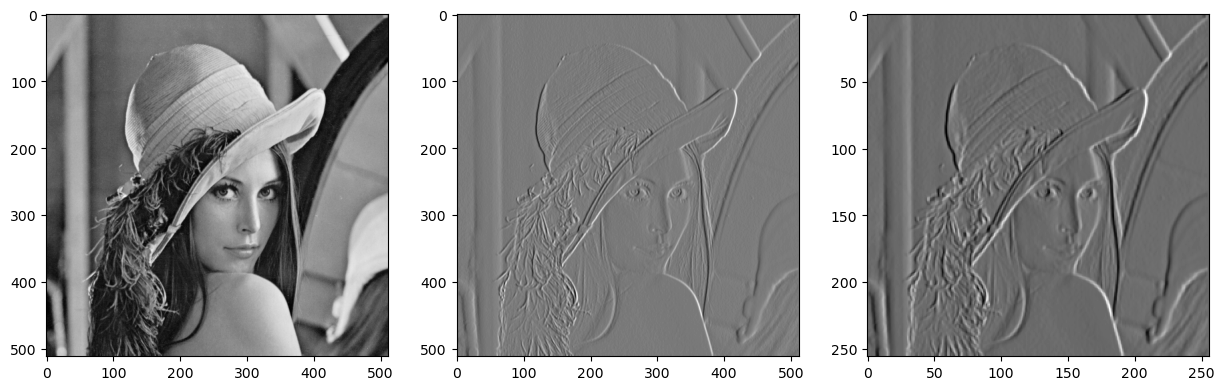

In [9]:
def sobel_filter_v(img):
    return cv2.filter2D(img, -1, sobel_kernel_v)


showcase_filter(sobel_filter_v)
# e) berücksichtigt nur vertikale Kanten, feste Filtergröße

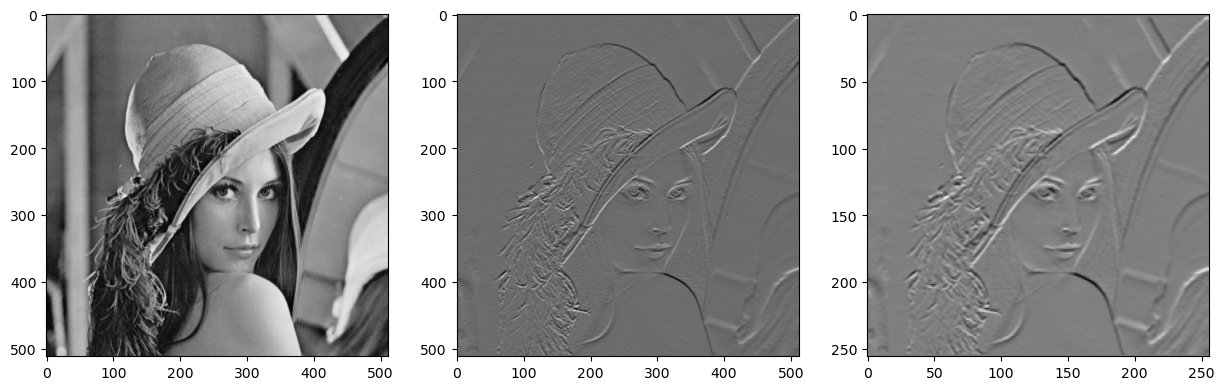

In [10]:
def sobel_filter_h(img):
    return cv2.filter2D(img, -1, sobel_kernel_v.T)


showcase_filter(sobel_filter_h)
# e) berücksichtigt nur horizontale Kanten, feste Filtergröße

c) LoG Filter

In [11]:
# aus letzter Übung
def gaussian_kernel(size, sigma):
    if size % 2 == 0: raise Exception("Filter bitte nur mit ungerader Größe")
    x = np.linspace(-(size - 1) / 2, (size - 1) / 2, size)
    gauss_1d = (1 / np.sqrt(2 * np.pi * sigma)) * np.exp(-0.5 * np.square(x) / np.square(sigma))
    gauss_2d = np.outer(gauss_1d, gauss_1d)
    gauss_2d = gauss_2d / gauss_2d.sum()
    return gauss_2d

In [12]:
log_kernel = signal.convolve2d(laplace_kernel, gaussian_kernel(3, 1))
# log_kernel = cv2.filter2D(np.pad(gaussian_kernel(3,1),1 ), -1, laplace_kernel, borderType=cv2.BORDER_CONSTANT)
log_kernel

array([[ 0.        ,  0.07511361,  0.1238414 ,  0.07511361,  0.        ],
       [ 0.07511361, -0.05277163, -0.14095844, -0.05277163,  0.07511361],
       [ 0.1238414 , -0.14095844, -0.32135421, -0.14095844,  0.1238414 ],
       [ 0.07511361, -0.05277163, -0.14095844, -0.05277163,  0.07511361],
       [ 0.        ,  0.07511361,  0.1238414 ,  0.07511361,  0.        ]])

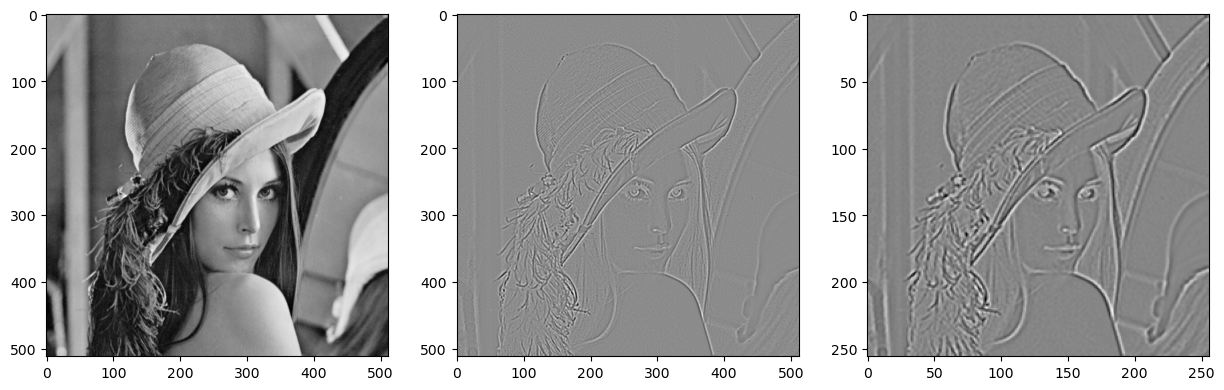

In [13]:
def log_filter(img):
    return cv2.filter2D(img, -1, log_kernel)


showcase_filter(log_filter)
# e) variable Filtergröße durch größe des gaußfilters, rechenaufwändiger

d) DoG Filter

In [12]:
g1 = gaussian_kernel(3, 2)
g1[1][1] = g1[1][1] - 1
g2 = gaussian_kernel(3, 2)

dog_kernel = signal.convolve2d(4 * g1, g2)
dog_kernel

array([[ 0.04150841,  0.09407038,  0.13631467,  0.09407038,  0.04150841],
       [ 0.09407038, -0.19428084, -0.15279703, -0.19428084,  0.09407038],
       [ 0.13631467, -0.15279703, -0.07554388, -0.15279703,  0.13631467],
       [ 0.09407038, -0.19428084, -0.15279703, -0.19428084,  0.09407038],
       [ 0.04150841,  0.09407038,  0.13631467,  0.09407038,  0.04150841]])

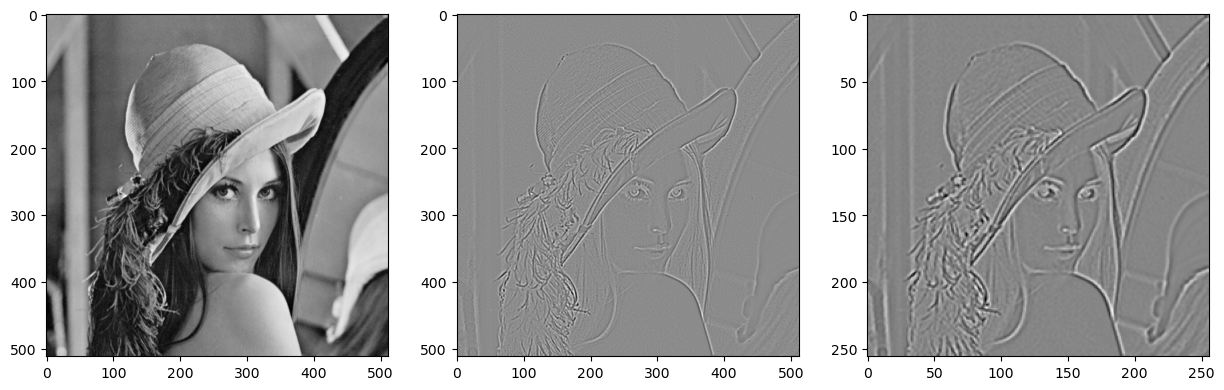

In [13]:
def dog_filter(img):
    return cv2.filter2D(img, -1, dog_kernel)


showcase_filter(log_filter)
# variable Filtergröße, Annäherung an LoG, feine kontrolle durch beide sigmas

e) Vor- und Nachteile der Kantendetektoren

f) Bild auf verschiedene Größen (z.B. 50 und 200
Prozent) skalieren und Kantenfilter anwenden

## 2. Gauss Laplace Pyramide

In [31]:
def build_gaussian_pyramid(img, num_levels):
    pyramid = [img]
    current_level = img
    for _ in range(num_levels):
        height, width = current_level.shape
        current_level = cv2.GaussianBlur(current_level, (15, 15), 7)
        current_level = cv2.resize(current_level, (width // 2, height // 2))
        pyramid.append(current_level)
    return pyramid


def build_gaussian_laplacian_pyramid(gaussian_pyramid):
    pyramid = []
    for l1, l2 in zip(gaussian_pyramid, gaussian_pyramid[1:]):
        height, width = l1.shape
        # Upsample the downsampled image using bilinear interpolation
        upsampled = cv2.resize(l2, (width, height), interpolation=cv2.INTER_LINEAR)

        # Calculate the Laplacian by subtracting the upsampled image from the current level
        laplacian = cv2.subtract(l1, upsampled)
        pyramid.append(laplacian)
    pyramid.append(gaussian_pyramid[-1])
    return pyramid

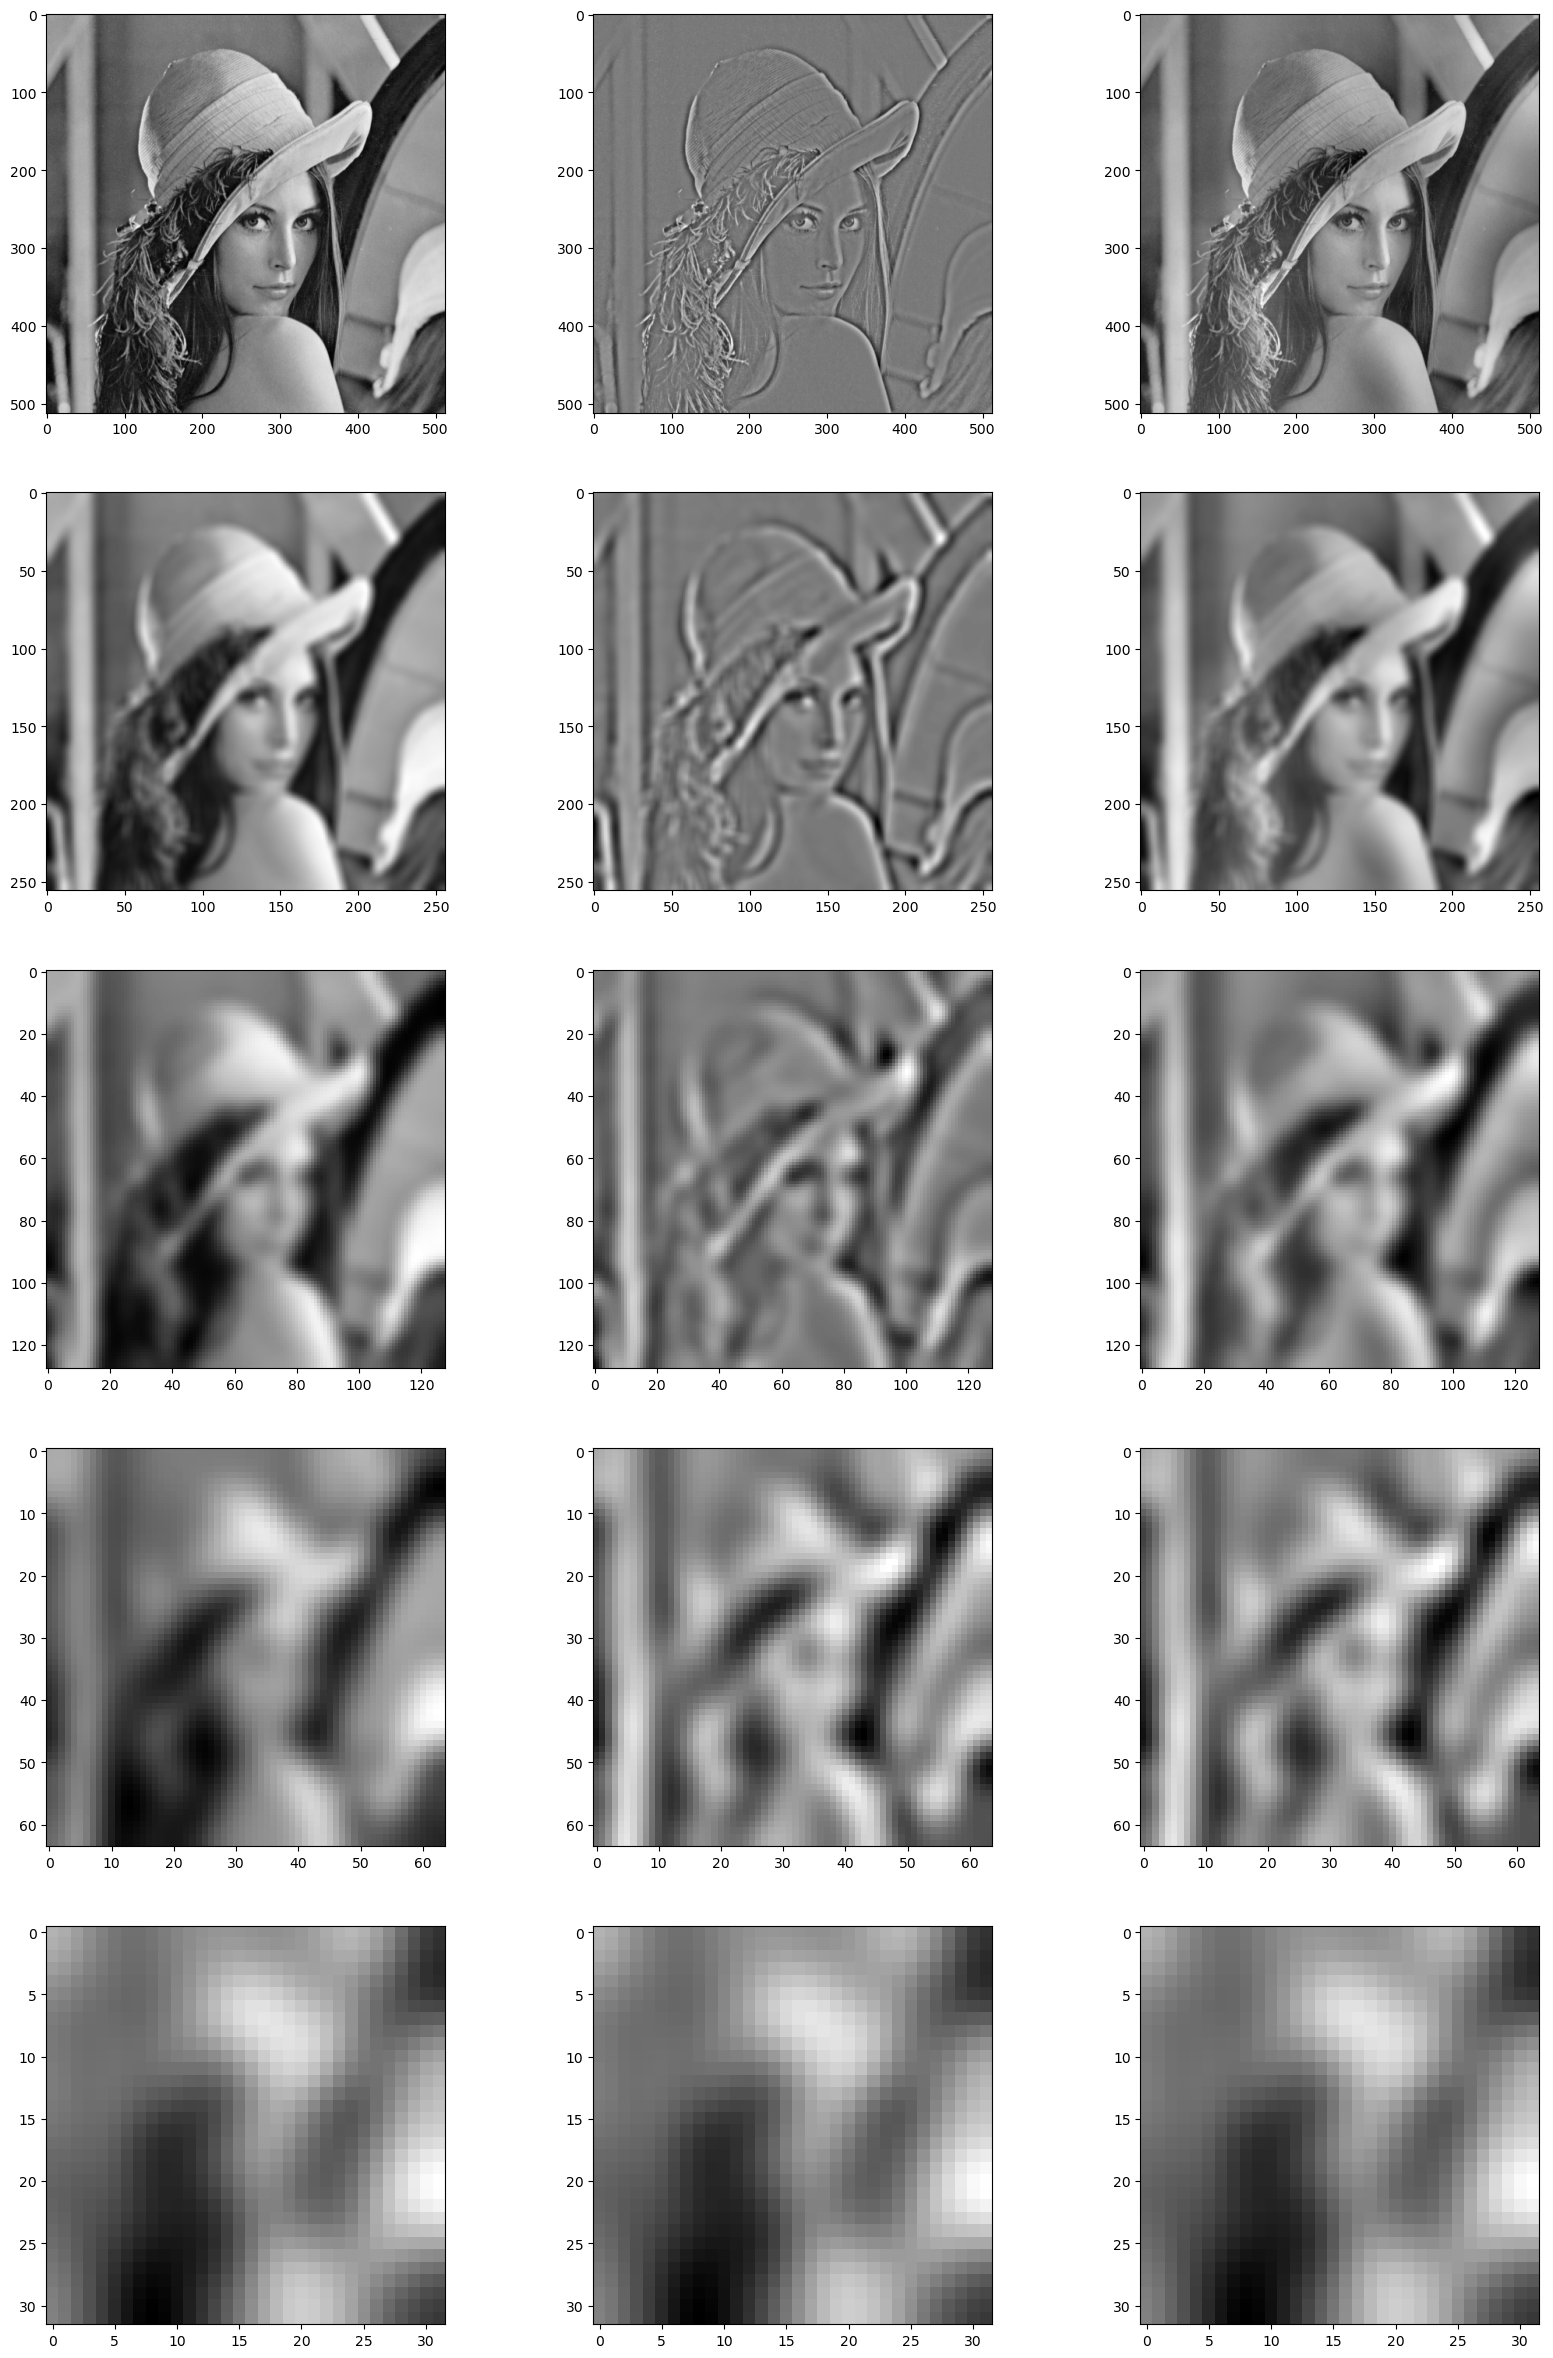

In [32]:
gaussian_pyramid = build_gaussian_pyramid(gray, 4)
laplacian_pyramid = build_gaussian_laplacian_pyramid(gaussian_pyramid)

fig, ax = plt.subplots(len(gaussian_pyramid), 3, figsize=(20, 30))
for i, level in enumerate(gaussian_pyramid):
    ax[i][0].imshow(level, cmap=plt.get_cmap('gray'))

for i, level in enumerate(laplacian_pyramid):
    ax[i][1].imshow(level, cmap=plt.get_cmap('gray'))

ax[4][2].imshow(level, cmap=plt.get_cmap('gray'))
steps = laplacian_pyramid[::-1]
reconstructed = steps[1]
for i, level in enumerate(steps[1:]):
    reconstructed = cv2.add(cv2.resize(reconstructed, level.shape, interpolation=cv2.INTER_LINEAR), level)
    ax[len(laplacian_pyramid) - 2 - i][2].imshow(reconstructed, cmap=plt.get_cmap('gray'))

plt.show()

## 3. Dilation und Erosion

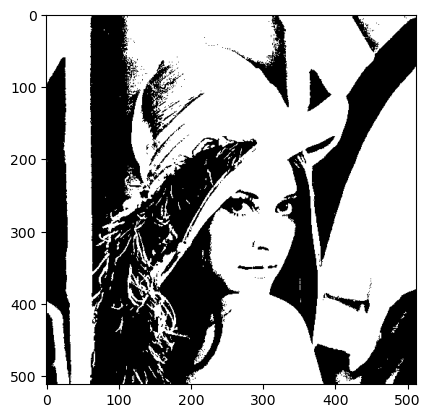

In [18]:
binary = 1.0 * (gray > 115)
plt.imshow(binary, cmap=plt.get_cmap('gray'))
plt.show()

In [19]:
kernel = np.ones((5, 5), np.uint8)

a) Dilation

In [20]:
img_dilation = cv2.dilate(binary, kernel, iterations=1)

b) Erosion

In [21]:
img_erosion = cv2.erode(binary, kernel, iterations=1)

c) Opening

In [22]:
img_opening = cv2.dilate(cv2.erode(binary, kernel, iterations=1), kernel, iterations=1)

d) Closing

In [23]:
img_closing = cv2.erode(cv2.dilate(binary, kernel, iterations=1), kernel, iterations=1)

e) Plotten der Ergebnisse

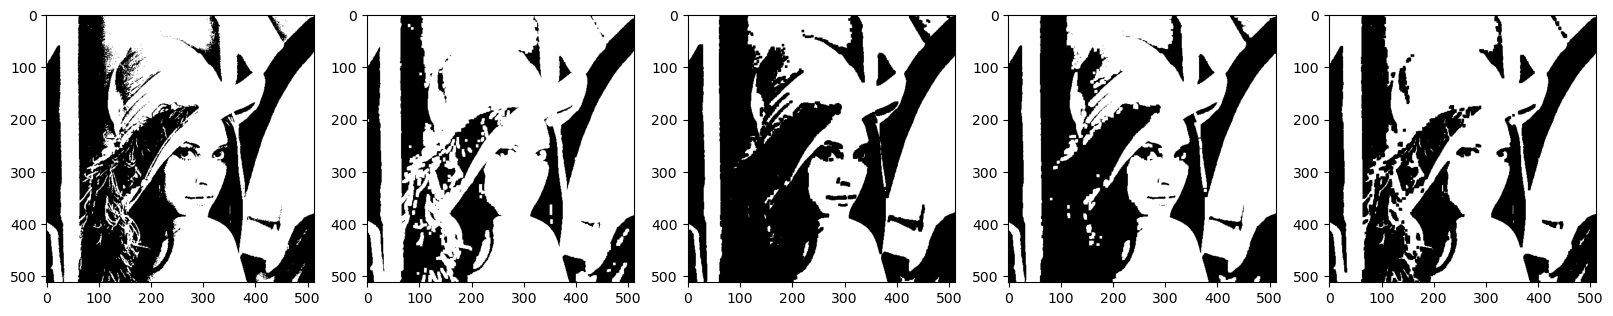

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))

ax[0].imshow(binary, cmap=plt.get_cmap('gray'))
ax[1].imshow(img_dilation, cmap=plt.get_cmap('gray'))
ax[2].imshow(img_erosion, cmap=plt.get_cmap('gray'))
ax[3].imshow(img_opening, cmap=plt.get_cmap('gray'))
ax[4].imshow(img_closing, cmap=plt.get_cmap('gray'))

plt.show()

## 4. Ausdünnung

In [25]:
filters = [
    np.array([
        [-1, 0, 1],
        [-1, 1, 1],
        [-1, 0, 1],
    ], np.int8),
    np.array([
        [-1, -1, 0],
        [-1, 1, 1],
        [0, 1, 1],
    ], np.int8),
    np.array([
        [-1, -1, -1],
        [0, 1, 0],
        [1, 1, 1],
    ], np.int8),
    np.array([
        [0, -1, -1],
        [1, 1, -1],
        [1, 1, 0],
    ], np.int8),
    np.array([
        [1, 0, -1],
        [1, 1, -1],
        [1, 0, -1],
    ], np.int8),
    np.array([
        [1, 1, 0],
        [1, 1, -1],
        [0, -1, -1],
    ], np.int8),
    np.array([
        [1, 1, 1],
        [0, 1, 0],
        [-1, -1, -1],
    ], np.int8),
    np.array([
        [0, 1, 1],
        [-1, 1, 1],
        [-1, -1, 0],
    ], np.int8),
]

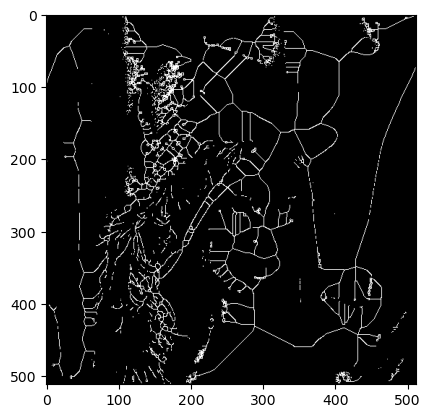

In [34]:
from copy import deepcopy

img = deepcopy(binary)
t = True
while t:
    last_img = deepcopy(img)
    current = np.zeros(img.shape)
    for filter in filters:
        filtered = cv2.morphologyEx(np.asarray(img, dtype=np.uint8), cv2.MORPH_HITMISS, filter)
        current = cv2.add(np.asarray(current, dtype=np.uint8), filtered)
    img = cv2.subtract(np.asarray(img, dtype=np.uint8), current)
    if (np.asarray(last_img, dtype=np.uint8) == np.asarray(img, dtype=np.uint8)).all():
        t = False


plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()